In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras import layers, models, utils, callbacks # type: ignore

Loading Data

In [2]:
data_path = "../data/outputs/combined_dataset.parquet"
df = pd.read_parquet(data_path)

print("Dataset loaded successfully.")
print("Shape:", df.shape)
print(df.head())

Dataset loaded successfully.
Shape: (43819782, 8)
    latitude   longitude      dNBR      SPI      VCI      NDVI  severity  \
0  38.869878 -121.142532 -0.113606  0.66689  0.46255  0.589904  Unburned   
1  38.869878 -121.142532 -0.113606  0.66689  0.46255  0.393256  Unburned   
2  38.869878 -121.142532 -0.113606  0.66689  0.46255  0.377522  Unburned   
3  38.869878 -121.142083 -0.010457  0.66689  0.46255  0.653064  Unburned   
4  38.869878 -121.142083 -0.010457  0.66689  0.46255  0.423746  Unburned   

  fire_name  
0    Caldor  
1    Caldor  
2    Caldor  
3    Caldor  
4    Caldor  


Data Preprocessing

In [3]:
le = LabelEncoder()
df['severity_encoded'] = le.fit_transform(df['severity'])
print("\nEncoded classes:", dict(zip(le.classes_, le.transform(le.classes_))))

features = ['dNBR', 'SPI', 'VCI', 'NDVI']
target = 'severity_encoded'

X_train, X_test, y_train, y_test = train_test_split(
    df[features],
    df[target],
    test_size=0.3,
    stratify=df[target],
    random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Encoded classes: {'High': np.int64(0), 'Low': np.int64(1), 'Moderate': np.int64(2), 'Unburned': np.int64(3)}


Reshape Data for CNN Input

In [4]:
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], 4, 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], 4, 1)

num_classes = len(np.unique(y_train))
y_train_cat = utils.to_categorical(y_train, num_classes)
y_test_cat = utils.to_categorical(y_test, num_classes)

print(f"Input shape for CNN: {X_train_cnn.shape}")
print(f"Number of classes: {num_classes}")

Input shape for CNN: (30673847, 4, 1)
Number of classes: 4


Address Class Imbalance

In [5]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print("\nClass weights:", class_weights)


Class weights: {0: np.float64(14.177514702646938), 1: np.float64(3.535348940242923), 2: np.float64(19.10072046827324), 3: np.float64(0.2782218337945232)}


Define CNN Model

In [6]:
cnn_model = models.Sequential([
    layers.Conv1D(32, kernel_size=2, activation='relu', input_shape=(4, 1)),
    layers.BatchNormalization(),
    layers.Conv1D(64, kernel_size=2, activation='relu'),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()

c:\Users\John Waugh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 3, 32)          │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 3, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2, 64)          │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,156 (51.39 KB)

 Trainable params: 12,964 (50.64 KB)

 Non-trainable params: 192 (768.00 B)

Model Training

In [7]:
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = cnn_model.fit(
    X_train_cnn, y_train_cat,
    validation_data=(X_test_cnn, y_test_cat),
    epochs=25,
    batch_size=1024,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/25
29955/29955 ━━━━━━━━━━━━━━━━━━━━ 165s 5ms/step - accuracy: 0.9866 - loss: 0.0755 - val_accuracy: 0.9980 - val_loss: 0.0048
Epoch 2/25
29955/29955 ━━━━━━━━━━━━━━━━━━━━ 167s 6ms/step - accuracy: 0.9965 - loss: 0.0251 - val_accuracy: 0.9982 - val_loss: 0.0045
Epoch 3/25
29955/29955 ━━━━━━━━━━━━━━━━━━━━ 166s 5ms/step - accuracy: 0.9972 - loss: 0.0165 - val_accuracy: 0.9907 - val_loss: 0.0594
Epoch 4/25
29955/29955 ━━━━━━━━━━━━━━━━━━━━ 191s 6ms/step - accuracy: 0.9973 - loss: 0.0151 - val_accuracy: 0.9969 - val_loss: 0.0082
Epoch 5/25
29955/29955 ━━━━━━━━━━━━━━━━━━━━ 189s 6ms/step - accuracy: 0.9977 - loss: 0.0134 - val_accuracy: 0.9990 - val_loss: 0.0023
Epoch 6/25
29955/29955 ━━━━━━━━━━━━━━━━━━━━ 188s 6ms/step - accuracy: 0.9976 - loss: 0.0155 - val_accuracy: 0.9964 - val_loss: 0.0125
Epoch 7/25
29955/29955 ━━━━━━━━━━━━━━━━━━━━ 194s 6ms/step - accuracy: 0.9978 - loss: 0.0115 - val_accuracy: 0.9979 - val_loss: 0.0056
Epoch 8/25
29955/29955 ━━━━━━━━━━━━━━━━━━━━ 193s 6ms/step - ac

Model Evaluation

410811/410811 ━━━━━━━━━━━━━━━━━━━━ 445s 1ms/step - accuracy: 0.9990 - loss: 0.0023

CNN Test Accuracy: 0.9990
410811/410811 ━━━━━━━━━━━━━━━━━━━━ 326s 792us/step

Classification Report (CNN):
              precision    recall  f1-score   support

        High       1.00      0.99      1.00    231810
         Low       0.99      0.99      0.99    929606
    Moderate       0.96      1.00      0.98    172061
    Unburned       1.00      1.00      1.00  11812458

    accuracy                           1.00  13145935
   macro avg       0.99      1.00      0.99  13145935
weighted avg       1.00      1.00      1.00  13145935



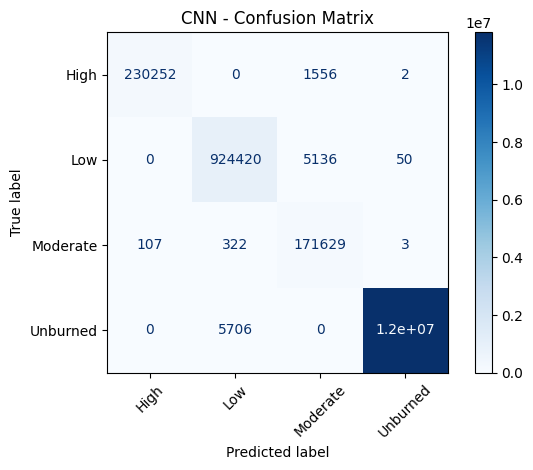

In [8]:
test_loss, test_acc = cnn_model.evaluate(X_test_cnn, y_test_cat)
print(f"\nCNN Test Accuracy: {test_acc:.4f}")

y_pred_probs = cnn_model.predict(X_test_cnn)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report (CNN):")
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("CNN - Confusion Matrix")
plt.tight_layout()
plt.show()

ROC AUC Evaluation

In [9]:
try:
    auc_macro = roc_auc_score(y_test_cat, y_pred_probs, multi_class='ovr', average='macro')
    print(f"Macro AUC: {auc_macro:.4f}")
except Exception as e:
    print("AUC computation failed:", e)

Macro AUC: 1.0000


Compare with Baseline Models


Model Comparison:
                 Model  Accuracy
0  Logistic Regression  0.999555
1        Random Forest  0.999999
2                  CNN  0.999020


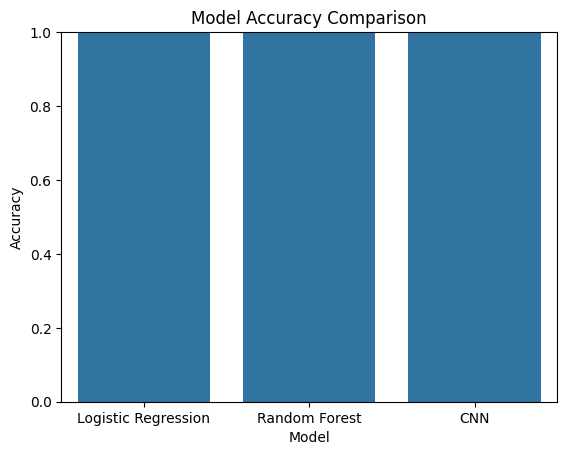

In [11]:
baseline_path = "../data/results/baseline_model_results.csv"
baseline = pd.read_csv(baseline_path)

baseline.columns = baseline.columns.str.strip().str.lower()

comparison = {
    'Model': ['Logistic Regression', 'Random Forest', 'CNN'],
    'Accuracy': [
        baseline.loc[baseline['model'] == 'Logistic Regression', 'accuracy'].values[0],
        baseline.loc[baseline['model'] == 'Random Forest', 'accuracy'].values[0],
        test_acc
    ]
}

comparison_df = pd.DataFrame(comparison)
print("\nModel Comparison:")
print(comparison_df)

sns.barplot(x='Model', y='Accuracy', data=comparison_df)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()

Save CNN Results

In [12]:
cnn_results = {
    'Model': 'CNN',
    'Accuracy': test_acc,
    'Macro_AUC': auc_macro,
}

results_path = "../data/results/cnn_results.csv"
pd.DataFrame([cnn_results]).to_csv(results_path, index=False)
print(f"\nCNN results saved to {results_path}")


CNN results saved to ../data/results/cnn_results.csv
